# Open-source ML Project: Improve Pet Adoption With Machine Learning And DagsHub, #1
## Building an application to predict cuteness of cats and dogs
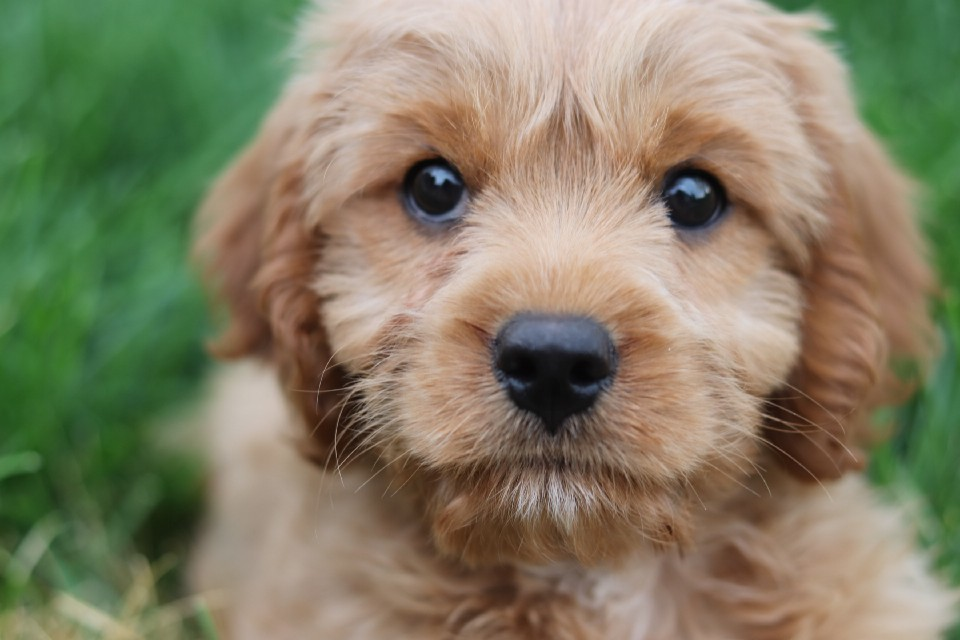
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://unsplash.com/@miaanderson?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText'>Mia Anderson</a>
        on 
        <a href='https://unsplash.com/s/photos/cute-puppy?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText'>Unsplash</a>
    </strong>
</figcaption>

### Setup

In [1]:
import os
import warnings
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.io import imread, imread_collection

warnings.filterwarnings("ignore")

### Introduction to the project

What is *cute*? Or what makes things cute? Well, the answers will be wildly different because it is such a subjective question. There is no definitive answer but according to Australian zoologist Konrad Lorenz, we consider things cute that look like human babies. 

Tiny, small body sizes with disproportionately large heads, big eyes along with round and soft body features - these are all the characteristics that are all found in little babies that we find *cute*. That is great and all, but can we ever teach mindless, emotionless machines what is cute and what isn't?

In this and in the coming couple of articles, we will try to answer this exact question using machine learning techniques.

### What does an open-source data project look like?

Most of the time, whenever we have a problem like predicting the cuteness of an animal using machine learning, we dive head-first and create a noteobook to explore the data. 

Then, we continue writing in the notebook and start building models in it. Then, we test those models in the same notebook. We might remember to pickle different versions once in a while, but only if we are in the mood. Ultimately, most our projects start with a notebook and end with it. 

Notebooks have ruined us. They kill open-source data projects. Usually, there is no point in tracking them with git. Why even bother with git when we are so lazy that we don't even create different notebooks for different tasks.

As a result, most of the GitHub profiles of data scientists look like this:

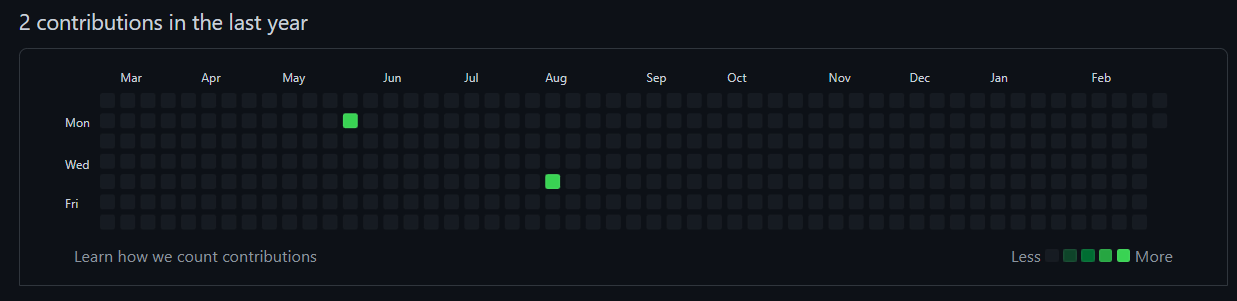

This is sad, very sad, indeed. 

But notebooks aren't the only problem. Many data projects pose major challenges to the very notion of reproducible, accessible and fast open-source projects. 

Today's dataset sizes have grown at such an alarming rate that tools for data versioning, data project collaboration are barely keeping up. The most powerful tool of programmers for project collaboration, Git, is utterly useless when it comes to track changes on large files. Even the creator of Git, Linus Torvalds, admits this. 

Machine learning process is iterative. We perform many experiments on the same data but with very different configurations - different processing tasks, models with hundred different hyperparameters. There is no logical way of keeping track of what works and what doesn't. If you are desperate, you might try keeping track of your ML experiments on Excel but ultimately, you will just end up miserable and give up.

Of course, people have tried to address all these issues and some were very successful. For example, there is DVC for version large files, MLFlow to manage experiments but these tools are completely separate entities. 

They don't work seamlessly with each other like software combinations in other programming disciplines like web or mobile development.

That's why there is now a completely separate growing field of machine learning - Machine Learning Operations (MLOps). It solely focuses on deploying and maintaining machine learning projects in as efficient and reliably as possible. MLOps focuses on reproduciblity of experiments, ease of collaboration between team members and applying software development best practices to version models, data and code.

One of the leading platforms for MLOps is [DagsHub](https://dagshub.com/). It puts together all the popular open-source tools to track experiments, version datasets and models, label data and visualize everything nicely.

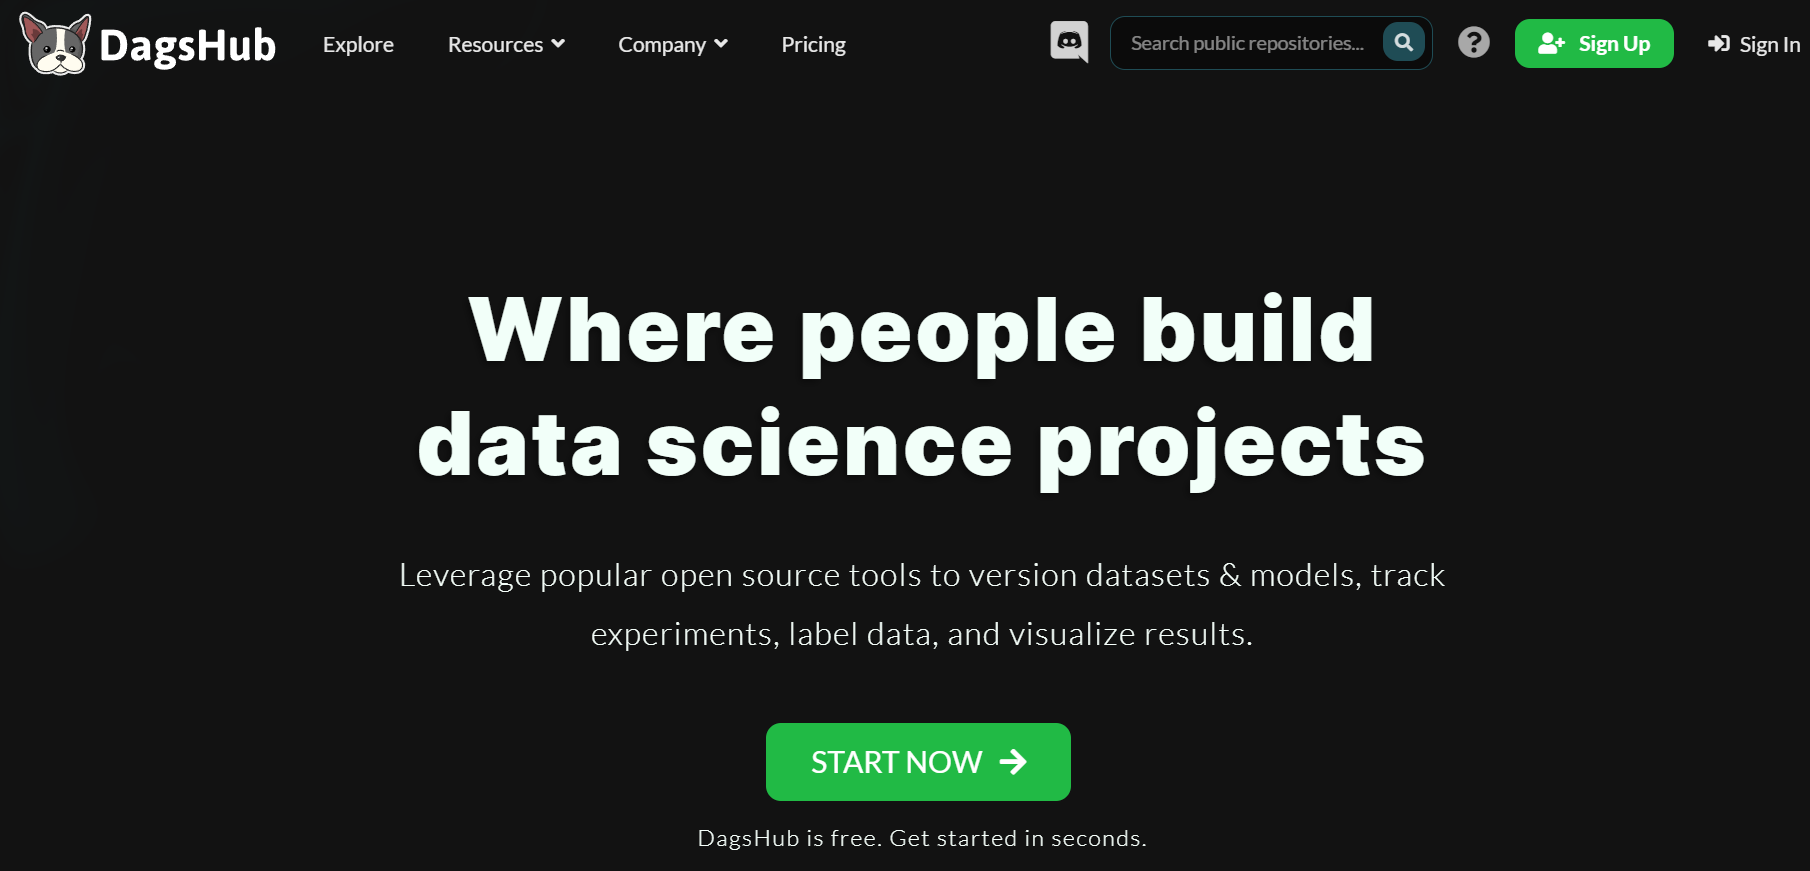

It is the complete copy of GitHub, with all its glory and pull requests by working with git repositories by default. 

It is also the only platform to offer a generous free storage for DVC so that you can version your datasets and models just like code. 

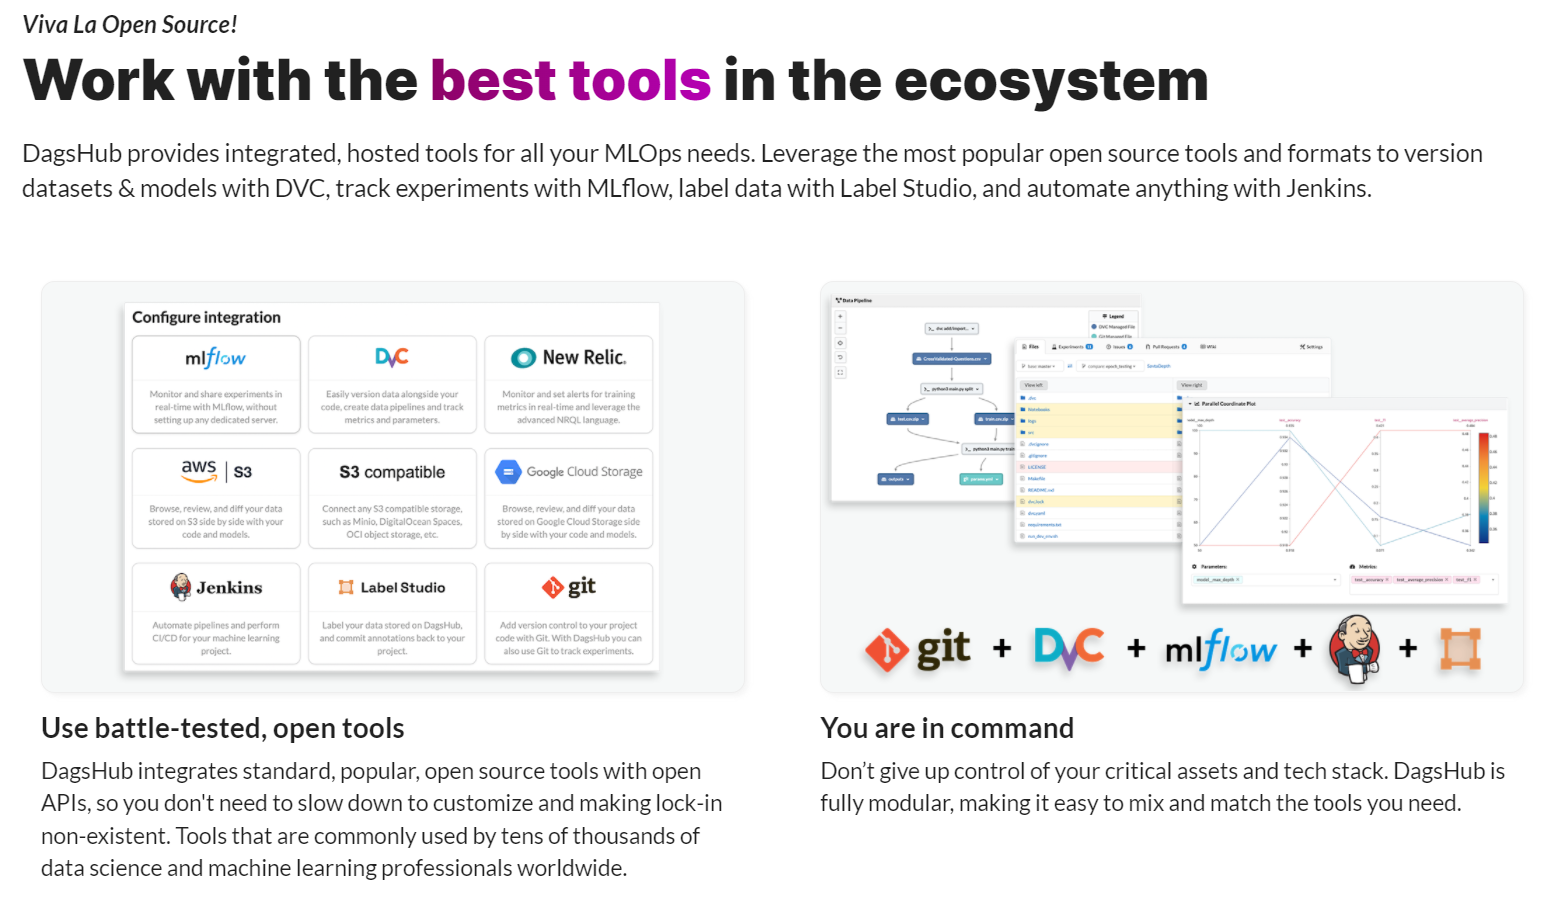

As we work this project, we will slowly learn and explore open-source development best practices for machine learning and see how DagsHub makes everything easy and effortless.

### Project setup

Let's start by performing the usual setup steps. We will create a `conda` environment with Python 3.8:

```bash
conda create --name pet_copy python=3.8 -y
conda activate pet_copy
```

You can add the `-y` tag so that you won't get asked to say "Yes" for the installations. 

After finishing the project code, we will be creating an application and host it on Streamlit cloud. Streamlit doesn't integrate with DagsHub yet, so we will be creating a temporary GitHub repository and link it to DagsHub later.

![](images/1.gif)

Clone the repository into your workspace:

```bash
git clone https://github.com/BexTuychiev/pet_copy.git
cd pet_copy
```

Now, if you go to your [DagsHub dashboard](https://dagshub.com/dashboard) and press the "create" button, you will see the "Connect a Repo" option. 

![](images/2.gif)

It will bring up a list of all your GitHub repos. Choose the one we just created and press "Connect Repository". This GitHub connection is also called a mirror - any commit or change pushed to GitHub will be reflected on DagsHub along with any changes through data version control (DVC). 

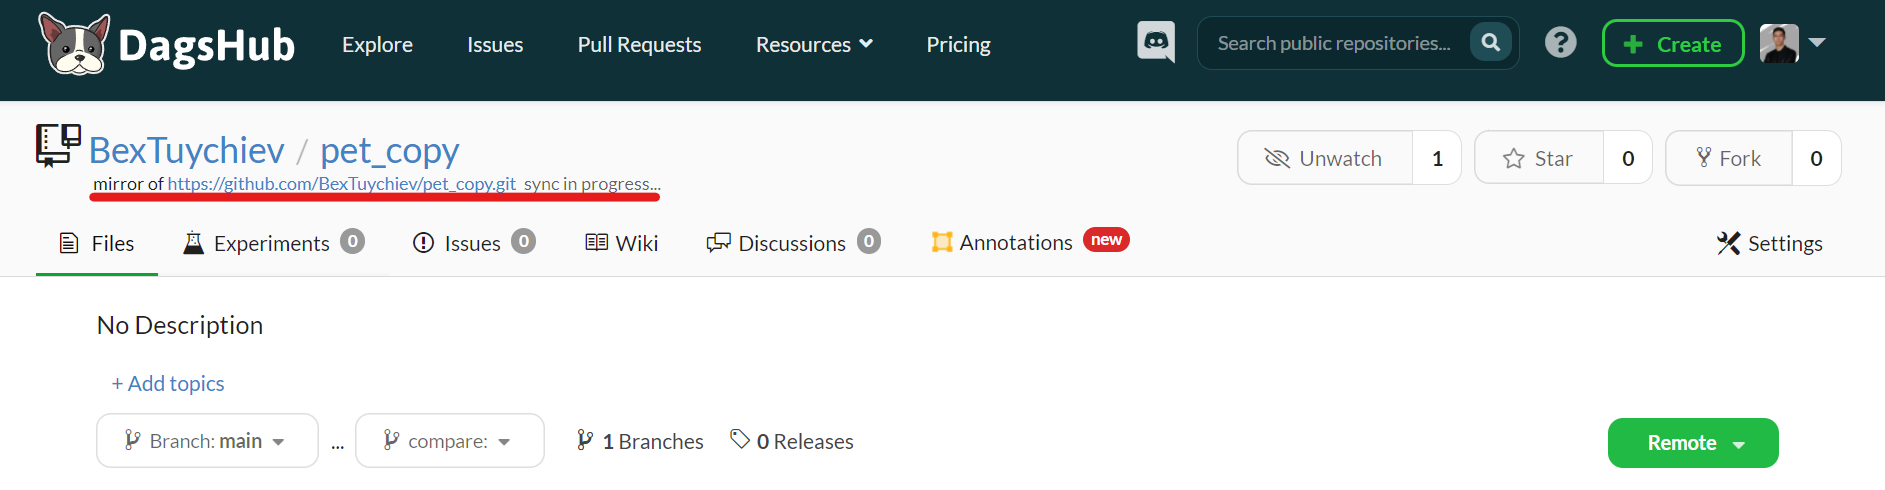

As you can see in the above screenshot, the repository page looks a lot like GitHub but with a few additions. The most important one to our project is the **Experiments** tab, which we will use extensively in the next part of the article. 

### DVC setup

Now, let's set up Data Version Control (DVC). Going back to the terminal, run the below command to install `dvc` making sure that the `conda` environment is activated:

```
pip install dvc
```

The installation will take a moment. When finished, we will call `dvc --version` to check that the installation was successful:

```
>>> dvc --version
2.9.3
```

Now, we can safely call the `dvc init` command to mark the current working directory as a DVC repository. 

```
dvc init
```

Initializing DVC creates a `.dvc` folder, which can be seen by running `git status`

```bash
git status -s
```
![](images/git_status.png)

This directory holds the project settings and configs just like the `.git` folder that gets created whenever you call `git init`. Most of the time, you won't open the files in this folder but if you are curious, you can read [this page](https://dvc.org/doc/user-guide/project-structure/dvc-files#dvc-files) of the DVC docs to understand how they work. 

For now, all you need to know is that they are just YAML files that give information of which files and directories are being tracked by DVC. Also, there is the `.dvcignore` file, which points to files that you want DVC to ignore. Note that some files can be added to both `.gitignore` or `.dvcignore` so they are visibly to you only. 

Well, if DVC tracks the large files and git tracks the code, who tracks these DVC metadata files? 

For two reasons, these are tracked by git itself. First, they are very small in size, so no need to add them to DVC. Second, when a teammate or a contributor clones or forks the repository, they should be able to get the exact state of the project at the latest commit. This requires the DVC files as well, because they contain the information regarding where all you store the large files and how they've been changing since the beginning. 

Therefore, let's add these new files to the git staging area and commit them:

```bash
git add .
git commit -m "Initialized DVC"
```

All git repositories have a remote storage, a place to host the code online, like DagsHub or GitHub. DVC is no different - it also needs a remote to store all the data it tracks. 

A DVC remote can be anything - a directory on your local machine, an AWS S3 or Google Cloud instance. We don't want to a local remote because we are building an open-source project and people should be able to access it. And linking to an S3 or Google Cloud is too much of a hassle. 

For these reasons, DVC has not been as popular among the open-source community at first. Fortunately, DagsHub solves the storage problem for DVC elegantly to make open-source data science accessible to everyone. A free account grants anyone 10 GB of storage specifically for DVC remote, which is more than enough for many small-to-medium projects.

The set up is also straightforward. By going to the repo page, you will see the "Remote" button, which contains the details of your DVC remote. Just copy the given commands and run them on the terminal. Don't forget to copy the commands with the given token:

![](images/3.gif)

```bash
dvc remote add origin https://dagshub.com/BexTuychiev/pet_copy.dvc
dvc remote modify origin --local auth basic
dvc remote modify origin --local user BexTuychiev
dvc remote modify origin --local password token
```

That's it. You've now configured remotes for both code and large files. Let's push the changes:

```bash
git push
dvc remote default origin
dvc push
```

Since we cloned the repo from GitHub, we don't have to specify the remote branch. As for DVC, we've named the remote DVC storage as `origin`, so in the second command, we are specifying it as our default remote. This enables us to call `dvc push` without specifying the remote branch every time.

Now, if you go to your repo page on DagsHub, you should see a page like below:

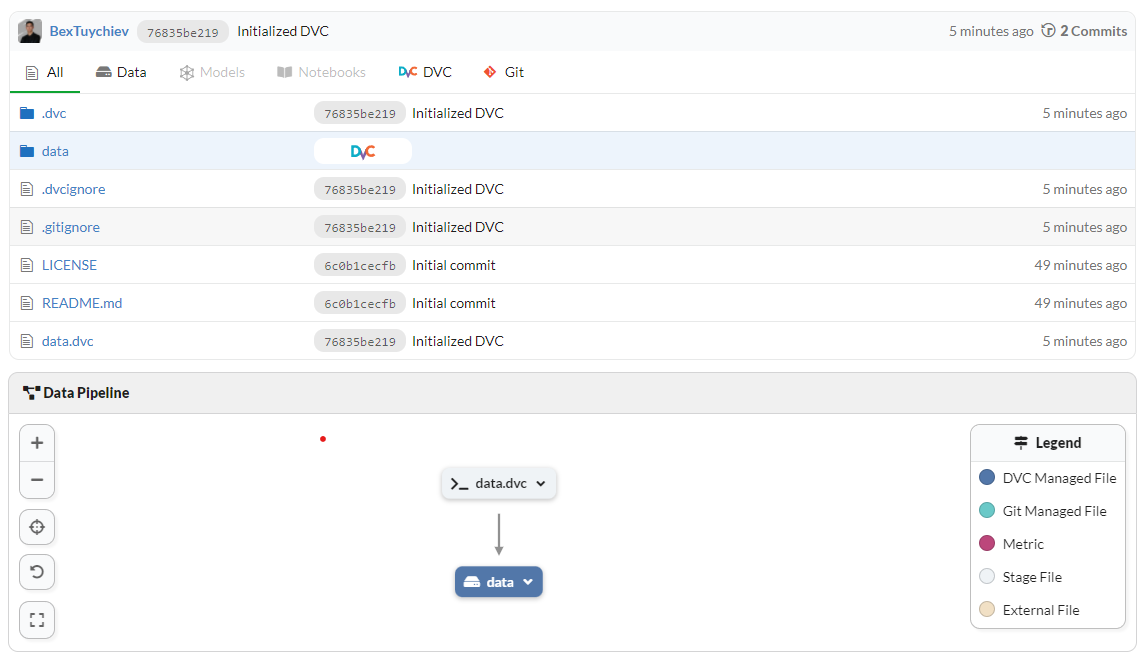

At the bottom, you will see the graph of our project, which is automatically generated by DagsHub. It doesn't show much now, but as we add preprocessing steps and models, it will change accordingly. Once the project is ready, it will serve as a general overview of the steps we've taken and it will be easier for others to build a mental picture of our project as a whole. This is much better than reading through the commit history. 

### Get the data

We will be using an image dataset provided by the good folks at [Petfinder.my](https://www.petfinder.my/) platform. It was used to generate a "Pawpularity" score for cats and dogs in a Kaggle competition. I've asked the permission to use their dataset in this and future articles related to this project.

In this section, we will only see how to load the data. We will explore it in detail in the coming section.

I've uploaded the dataset as a zip file to my own repository. You can download any file from a remote storage with a single command as long as it is being tracked by DVC itself. 

Call the `dvc get` command by providing the repository the file resides and specify its path like below:

```bash
dvc get https://dagshub.com/BexTuychiev/pet_pawpularity data/raw/petfinder-pawpularity-score.zip
```

This will download the zip file to the root directory. Unzip it and move all relevant files to the `data/raw` directory. You can remove the original zip file afterwards:

```
unzip petfinder-pawpularity-score.zip
mv train train.csv test test.csv data/raw
rm sample_submission.csv
rm petfinder-pawpularity-score.zip
```

Now, we need to tell DVC to track the `data` folder so that we don't accidentally commit it to git. The command is `dvc add dir-or-file`:

```bash
dvc add data
```

This will take a minute to finish since the dataset size is over 1 GB.

The `dvc add` command is like `git add`. Adding files to DVC with `add` puts them into DVC cache - think of it as an equivalent to git's staging area. Also, DVC automatically adds the path to these files to `.gitignore` so you don't have to do it manually. 

```
git status -s
```

Calling `dvc add` on a directory or a file also creates a new file with `.dvc` extension, which lets DVC know to track it. Adding a whole directory to DVC only creates a single `.dvc` files, regardless of how many files are in there. However, you can always tell DVC to track specific files by providing direct paths. 

To keep track of changes in terms of DVC, you can call `dvc status` as well. The command takes a while to run based on the size of the tracked files, but should become faster after the first run:

```bash
dvc status
```

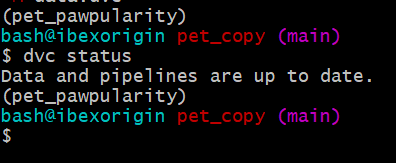

Now, let's add the created `.dvc` files to git and push all changes to remotes:

```bash
git add .
git commit -m "Add data files"

git push
dvc push
```

Notice that `git add` only takes a second to add the new files to staging area because DVC is taking care of all the large files.

So, here is a rule of thumb when working on a project with both git and DVC:

If there is a change in code, only commit it with git. If you add new large files or modify existing ones, call `dvc add` on them every time to take a snapshot of the changes. The command will create or update the relevant `.dvc` files, so you need to commit those changes to git. 

For most daily scenarios, knowing the `init, add, status, push` commands is enough but DVC offers much more features. You can learn more about it from the [docs](https://dvc.org/) or get another hands-on example from this [tutorial](https://realpython.com/python-data-version-control/).

Now, let's move on to exploratory data analysis.

### EDA on the metadata of images

As I mentioned earlier, we will be using the data from the Pet Pawpularity competition on Kaggle. In this competition, participants were asked to predict the "Pawpularity" score given an image of a dog or a cat. The labels for existing photos were provided by the Petfinder.my website, which uses a tool called [Cuteness Meter](https://petfinder.my/cutenessmeter) and a pet's pageview statistics to create a pseudo-cuteness score, hence *pawpularity*.

The dataset has about 10k pet images along with metadata for each one. In this section, we will look at this metadata files which are given as a CSV:

In [2]:
train_df = pd.read_csv("data/raw/train.csv")
test_df = pd.read_csv("data/raw/test.csv")

In [3]:
train_df.head()

Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  
0          0      1        0      0          0     0     0           63  
1          0      0        0      0          0     0     0           42  
2          0      0        0      1          1     0     0           28  
3          0      0        0      0          0     0     0           15  
4          0      1        0      0          0     0     0           72

In [4]:
test_df.head()

Id  Subject Focus  Eyes  Face  Near  Action  \
0  4128bae22183829d2b5fea10effdb0c3              1     0     1     0       0   
1  43a2262d7738e3d420d453815151079e              0     1     0     0       0   
2  4e429cead1848a298432a0acad014c9d              0     0     0     1       0   
3  80bc3ccafcc51b66303c2c263aa38486              1     0     1     0       0   
4  8f49844c382931444e68dffbe20228f4              1     1     1     0       1   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  
0          1      1        0      0          1     0     1  
1          0      1        1      0          0     0     0  
2          1      1        1      0          1     1     1  
3          0      0        0      0          0     1     0  
4          1      0        1      0          1     1     0

There are 13 features, the ID being the file name of the image and the rest are binary features related to image characteristics. The last "Pawpularity" column is the target. 

In [5]:
for col in train_df.columns.tolist()[:-1]:
    train_df[col] = train_df[col].astype("category")

In [6]:
train_df.drop("Id", axis=1).describe(exclude=np.number)

Subject Focus  Eyes  Face  Near  Action  Accessory  Group  Collage  \
count            9912  9912  9912  9912    9912       9912   9912     9912   
unique              2     2     2     2       2          2      2        2   
top                 0     1     1     1       0          0      0        0   
freq             9638  7658  8960  8540    9813       9240   8630     9420   

        Human  Occlusion  Info  Blur  
count    9912       9912  9912  9912  
unique      2          2     2     2  
top         0          0     0     0  
freq     8264       8207  9305  9214

In [7]:
print(
    f"There are {len(train_df)} observations in the metadata for"
    f"training images with {train_df.shape[1]} features."
)

There are 9912 observations in the metadata fortraining images with 14 features.


In [8]:
print(f"There are {len(test_df)} observations in the metadata for testing images.")

There are 8 observations in the metadata for testing images.


As you can see, there are 9912 observations in the training set while only 8 in the test. We will have to develop a solid validation strategy in the next part of the article, as there are very few test images. 

In [9]:
train_df.isna().sum().sum()

0

In [10]:
print(f"There are no missing values in the dataset.")

There are no missing values in the dataset.


In [11]:
train_df["Pawpularity"].describe()

count    9912.000000
mean       38.039044
std        20.591990
min         1.000000
25%        25.000000
50%        33.000000
75%        46.000000
max       100.000000
Name: Pawpularity, dtype: float64

The 5-number summary of the target tells us that the cuteness score ranges from 1 to 100, with a mean of 38 and 75% of images having a cuteness score of 46 or less. Let's look at a histogram for a better view at the target:

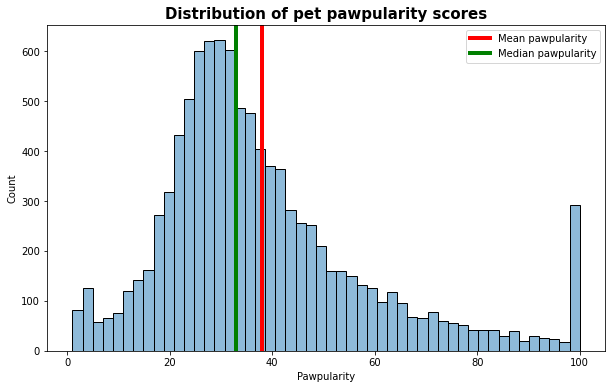

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(train_df["Pawpularity"], ax=ax, bins=50, alpha=0.5)

ax.set_title("Distribution of pet pawpularity scores", weight="bold", size=15)
plt.rc("axes", labelsize=15)

mean_pawpularity = train_df["Pawpularity"].mean()
median_pawpularity = train_df["Pawpularity"].median()
ax.axvline(mean_pawpularity, lw=4, color="r", label="Mean pawpularity")
ax.axvline(median_pawpularity, lw=4, color="green", label="Median pawpularity")

ax.legend();

We can see that there most pets are in the rage of 20-40. It is also surprising to see so many pets with maximum cuteness score. 

Since the features are all binary, we won't be able to extract much from them. So, we will look at the distribution of the target grouped by each feature. Let's see what each feature represents before we start plotting:

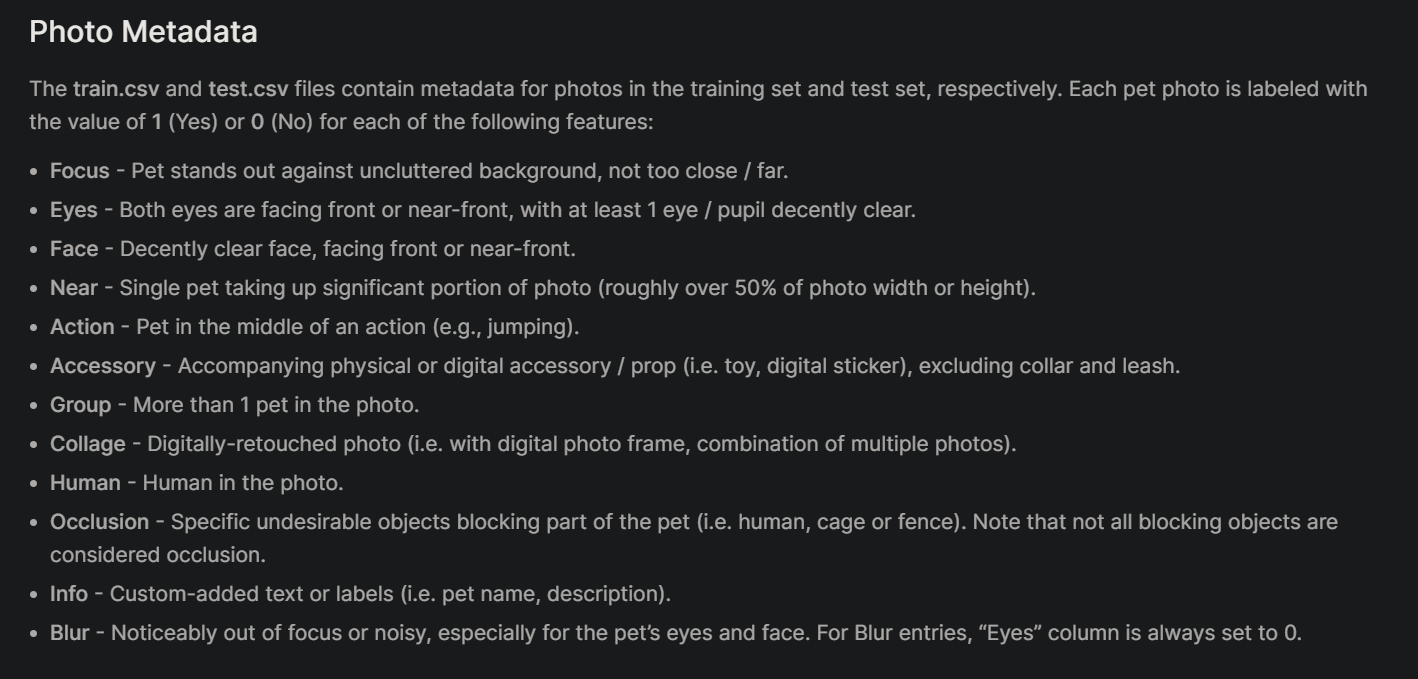
<figcaption style="text-align: center;">
    <strong>
        Screenshot from the data page of the competition.
    </strong>
</figcaption>

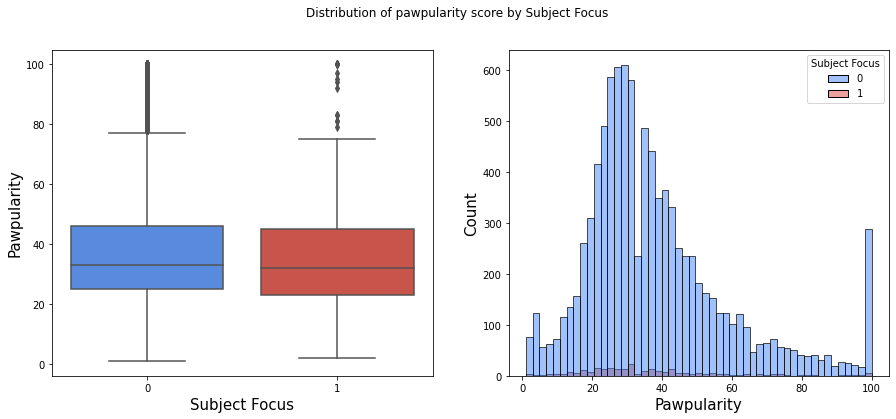

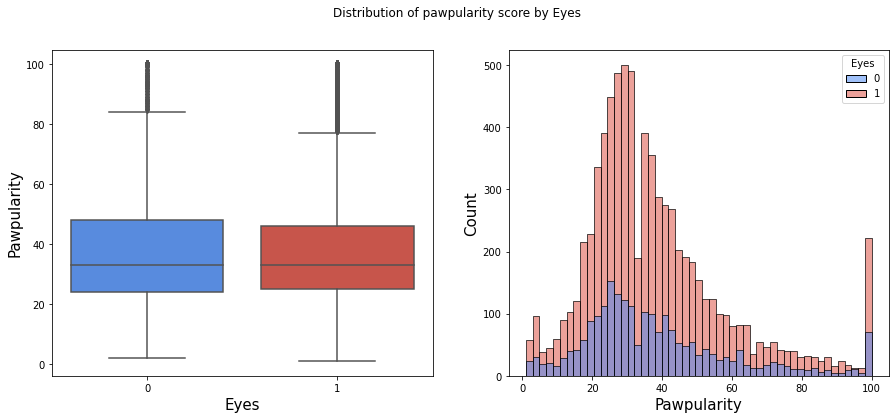

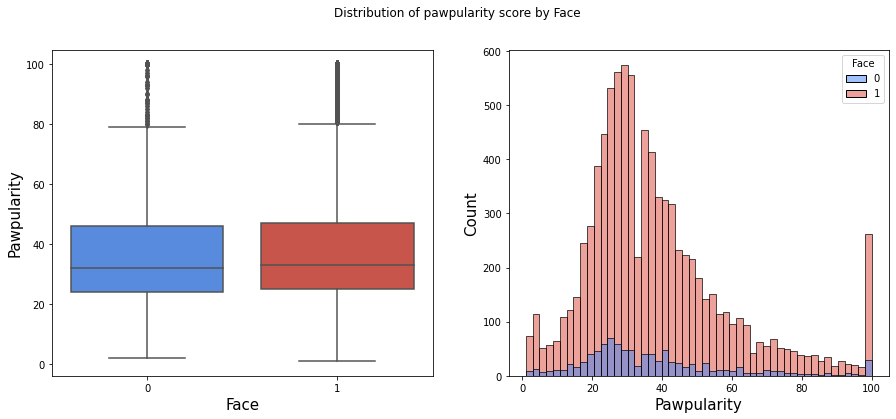

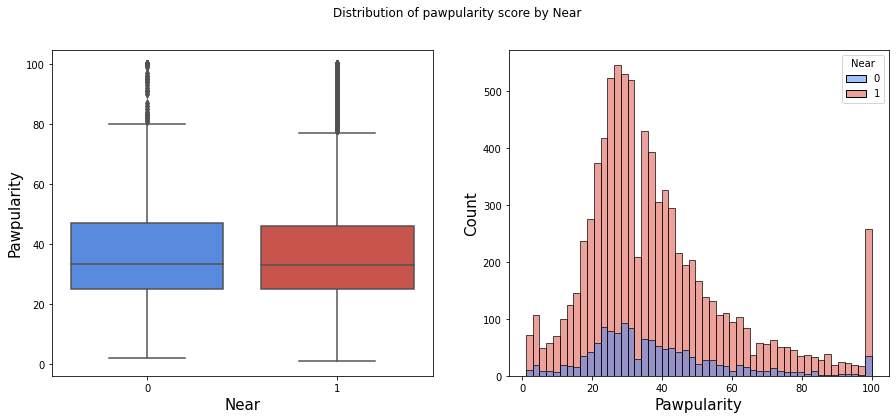

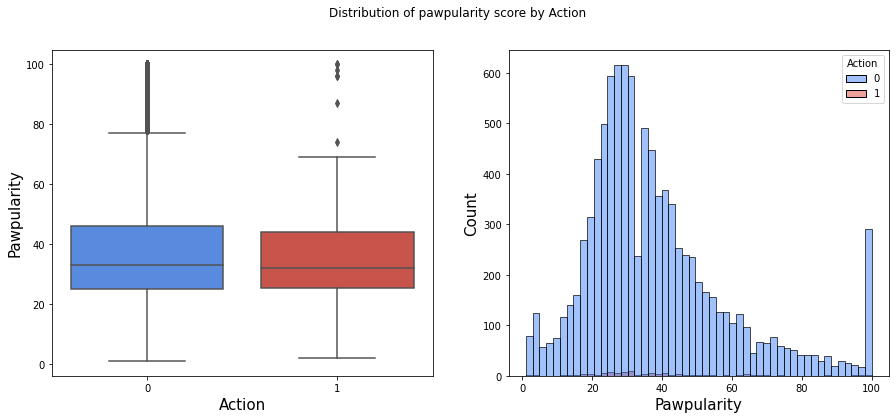

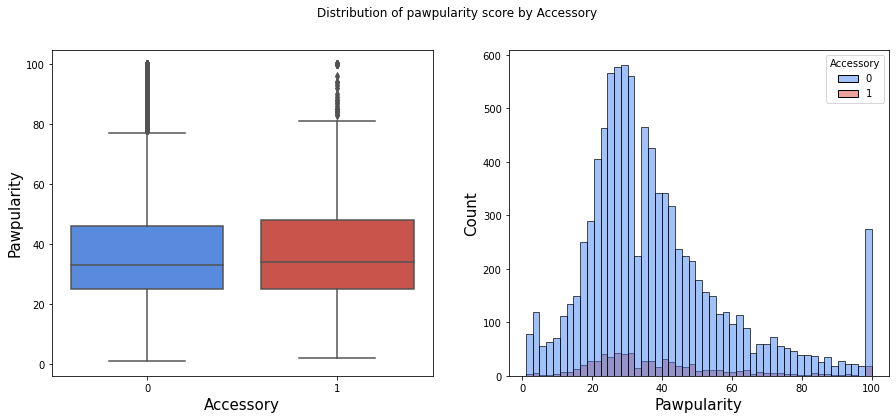

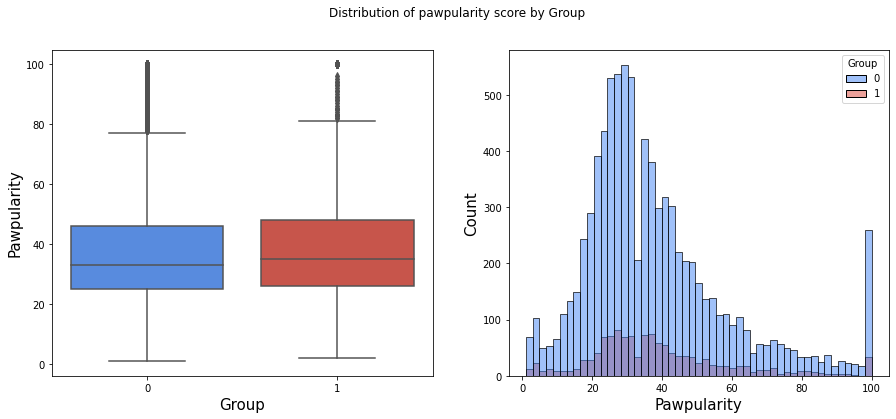

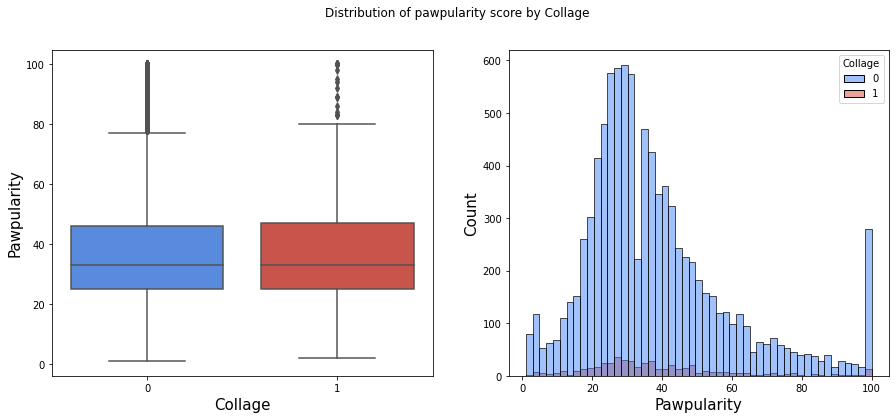

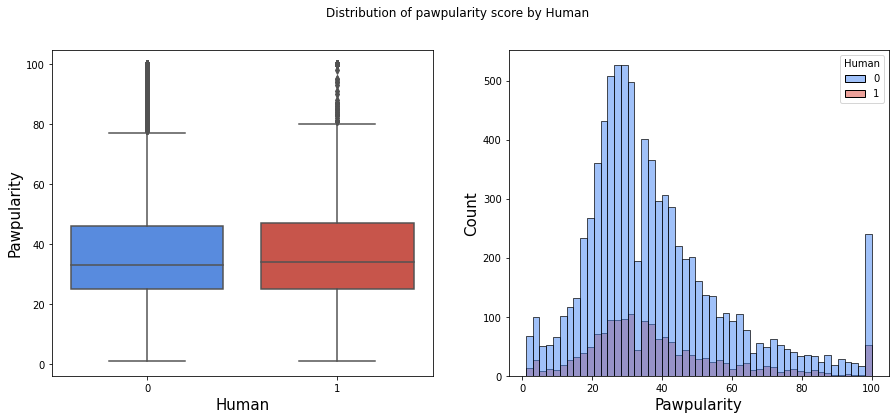

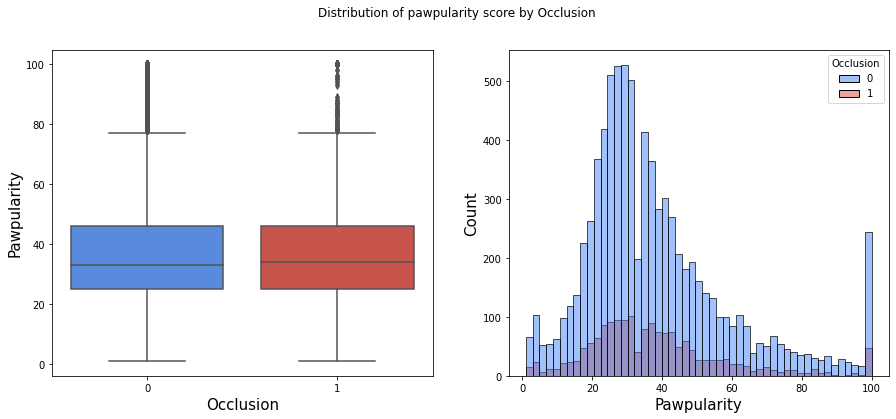

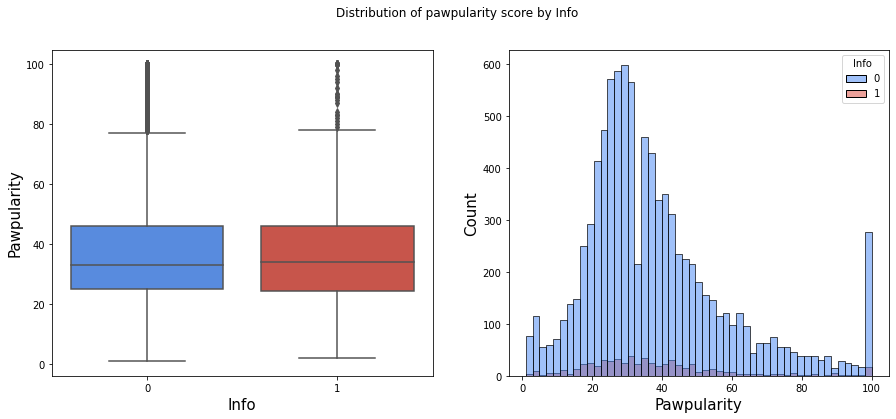

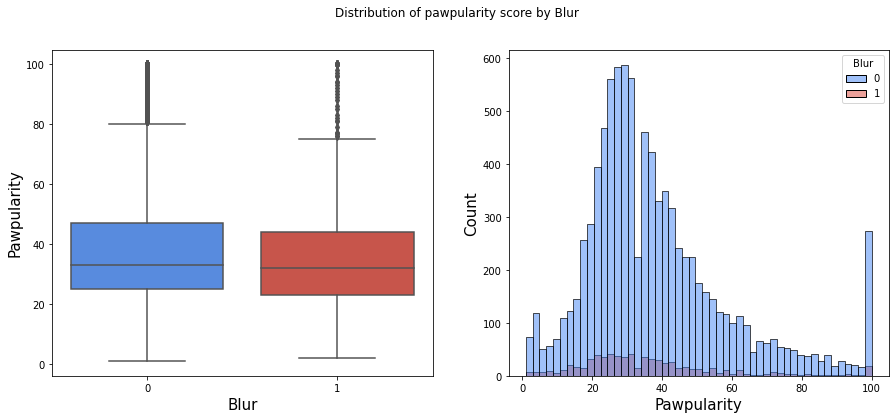

In [14]:
col_list = train_df.drop(["Id", "Pawpularity"], axis=1).columns.tolist()
target_name = "Pawpularity"
google_red_green = ["#4285F4", "#DB4437"]

for col in col_list:

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    sns.boxplot(x=col, y=target_name, data=train_df, ax=ax1, palette=google_red_green)
    sns.histplot(
        x=target_name, hue=col, data=train_df, ax=ax2, palette=google_red_green
    )

    fig.suptitle(f"Distribution of pawpularity score by {col}")

The boxplots show that even grouped by a feature, the target has similar distributions. The histograms confirm this. This indicates that when building a predictive model, these metadata features might not be much use.

Now, let's move on to exploring the images.

### EDA on the images

First, let's create a simple function that loads an image and plots it using Matplotlib:

In [38]:
def show(image: np.ndarray, title="Image", cmap_type="gray", axis=False):
    """
    A function to display np.ndarrays as images
    """
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    if not axis:
        plt.axis("off")
    plt.margins(0, 0)
    plt.show();

We will combine this function with another so that we can look at random images of pets every time we call it:

In [15]:
from skimage.io import imread


def draw_random_image(image_list):
    """A function to load random image path from a list and plots it."""
    img_rand = np.random.choice(image_list)

    show(imread(img_rand))

As we saw earlier, the metadata table contains the file name of each observation in the Id column. We will use it to build a list of all image paths using the Path class from `pathlib` module:

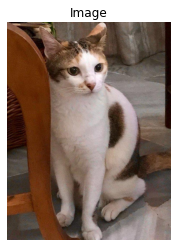

In [82]:
from pathlib import Path

image_paths_train = [
    "data/raw/train" / Path(path).with_suffix(".jpg") for path in train_df["Id"]
]

draw_random_image(image_paths_train)

You can have a bit of fun running the `draw_random_image` function over and over again.

In the meantime, let's look at the dimensions of images and how they differ. A scatterplot of width vs. height should gives a rough idea:

In [34]:
heights = list()
widths = list()

for path in image_paths_train:
    # Load the image
    image = imread(path)
    # Extract dimensions
    h, w = image.shape[0], image.shape[1]

    heights.append(h)
    widths.append(w)

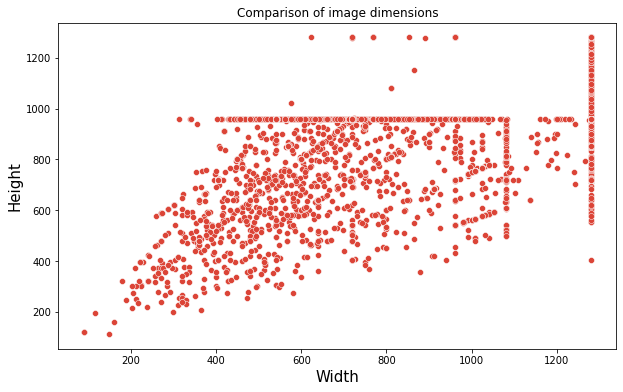

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(widths, heights, color="#DB4437", ax=ax)

ax.set(title="Comparison of image dimensions", xlabel="Width", ylabel="Height");

We can see that the image dimensions are wildly different. We will need to address this issue in the next article before building models. 

For now, let's look at pet photos at different cuteness levels to see if we can spot some patterns as to why they have different scores. To accomplish this, we will create a function that plots *n* random images of pets at a provided pawpularity level. Here it is:

In [36]:
def show_pawpularity_level(df, n=5, pawpularity=100):
    """
    A function to draw `n` number of random images at the given `pawpularity` level.
    """
    images_rnd = df[df["Pawpularity"] == pawpularity].sample(n)["Id"]

    fig, axes = plt.subplots(1, n, figsize=(n * 5, 6))

    for ax, img_id in zip(axes.flatten(), images_rnd):
        # Load the image
        path = "data/raw/train" / Path(img_id).with_suffix(".jpg")
        image = imread(path)

        ax.imshow(image)
        # Turn off axis
        ax.axis("off")

    fig.suptitle(f"Pets at pawpularity level {pawpularity}.", weight="bold", size=30)

Let's plot 5 different levels from 20 through 100:

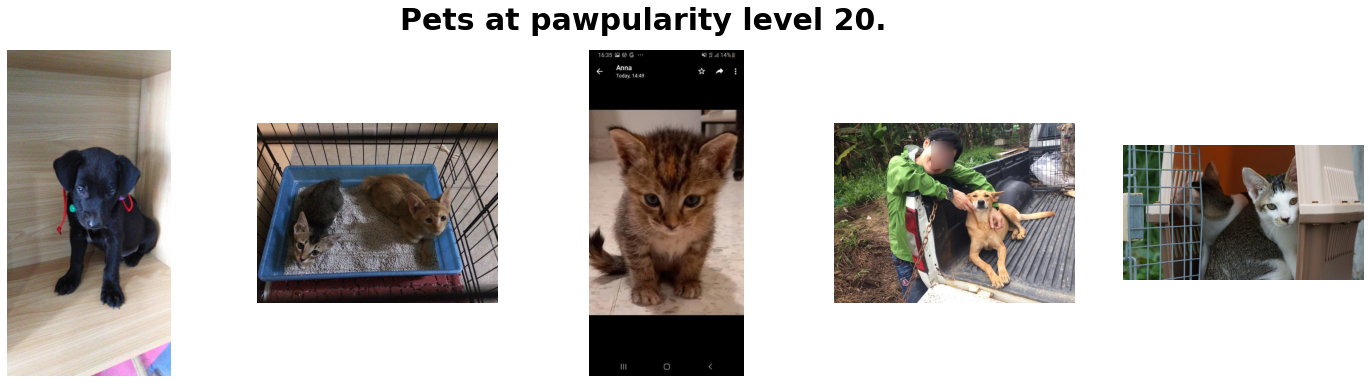

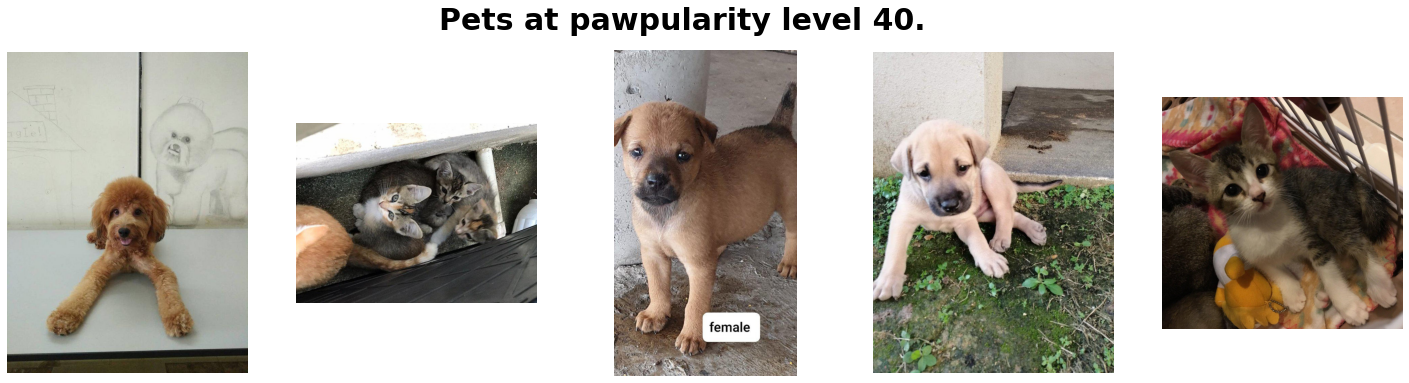

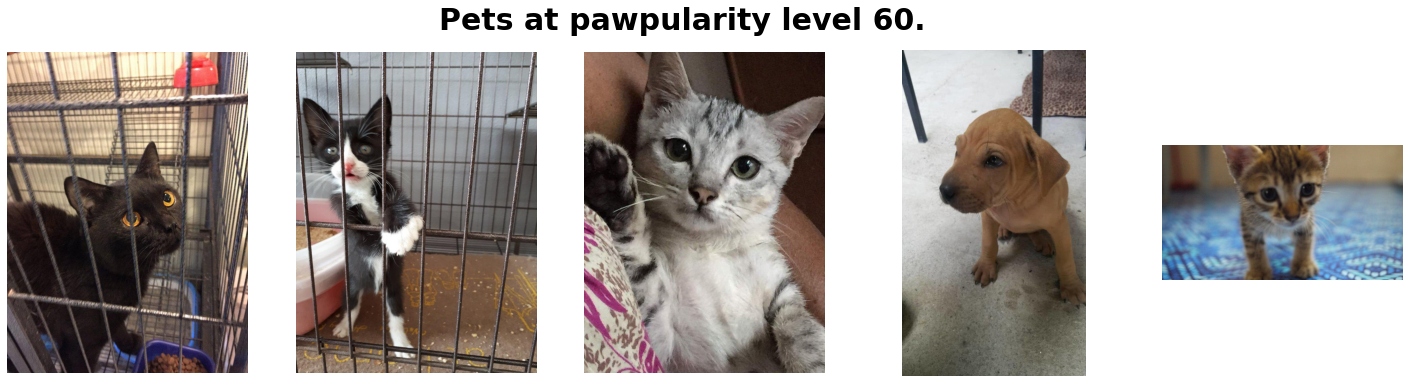

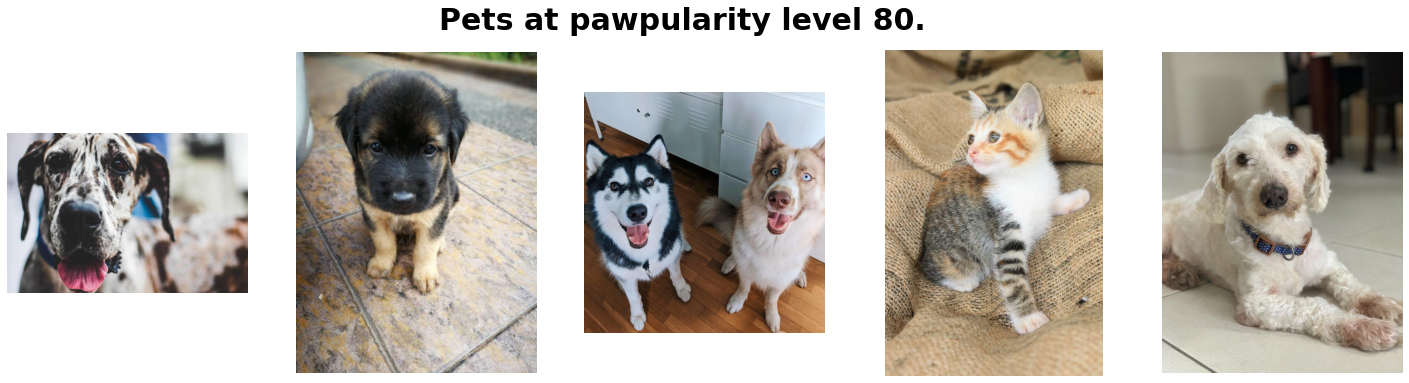

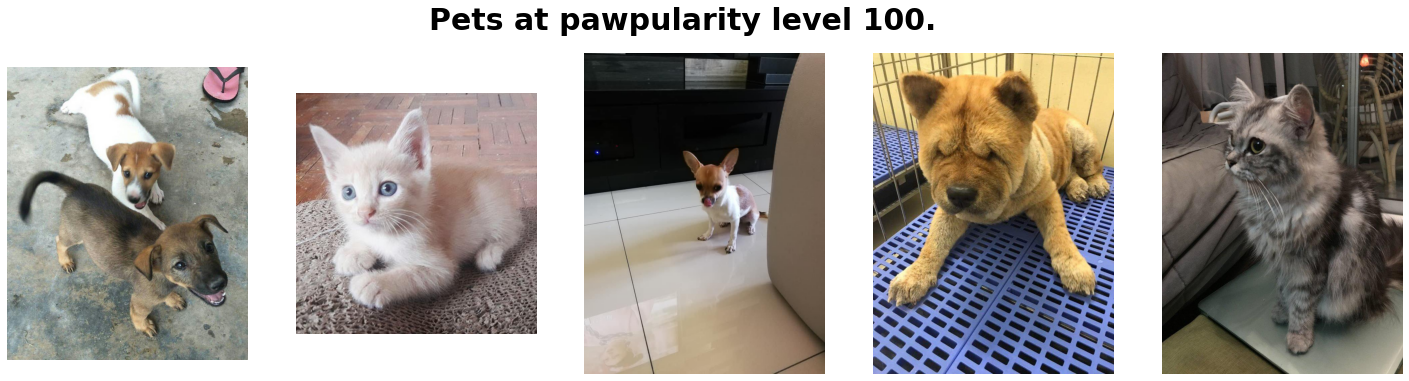

In [84]:
for level in range(20, 101, 20):
    show_pawpularity_level(train_df, pawpularity=level)

Running this function a few times shows that it is not very easy for us to discern any reasonable pattern as to why level 100 pets are more popular than lower level pets. 

As a final step, let's test our notion in the last section and see if fitting a model only to the metadata yields any significant results.

### Fitting a baseline model

As the target contains cuteness scores, it is a regression task by default. However, we can always consider it as a 100-class multiclass problem and fit a classifier. We will try both, starting with regression using Random Forests:

In [86]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold, cross_validate

X, y = train_df.drop(["Id", "Pawpularity"], axis=1), train_df[["Pawpularity"]]

In [88]:
%%time

# Init a regressor and a CV class
rf_reg = RandomForestRegressor(n_estimators=1000, random_state=1121218)
cv = KFold(n_splits=8)

cv_reg_scores = cross_validate(
    rf_reg,
    X,
    y,
    cv=cv,
    return_train_score=True,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

Wall time: 4.98 s


In [101]:
train_mean = np.sqrt(-cv_reg_scores["train_score"].mean())

print(f"Mean training RMSE is {round(train_mean, 3)}")

Mean training RMSE is 20.273


In [102]:
test_mean = np.sqrt(-cv_reg_scores["test_score"].mean())

print(f"Mean training RMSE is {round(test_mean, 3)}")

Mean training RMSE is 20.765


We are not overfitting but the score is terrible. The average margin of error for each image is about 20. Let's try the classifier:

In [103]:
%%time

# Init a classifier and a CV class
rf_reg = RandomForestClassifier(n_estimators=1000, random_state=1121218)
cv = KFold(n_splits=8)

cv_reg_scores = cross_validate(
    rf_reg,
    X,
    y,
    cv=cv,
    return_train_score=True,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

Wall time: 16.1 s


In [104]:
train_mean = np.sqrt(-cv_reg_scores["train_score"].mean())

print(f"Mean training RMSE is {round(train_mean, 3)}")

Mean training RMSE is 26.314


In [105]:
test_mean = np.sqrt(-cv_reg_scores["test_score"].mean())

print(f"Mean training RMSE is {round(test_mean, 3)}")

Mean training RMSE is 27.25


The classifier is even more disappointing. 

The next article will solely focus on trying to improve this score using the images and deep learning techniques. 

### Conclusion